In [51]:
subj = "Subj3"
exp = "exp_merged"

n_stages = [ 9, 8, 10 ][int(subj[-1:]) - 1]
scale = False

### Imports

In [52]:
%load_ext autoreload
%autoreload 2

import os

import SDA
import SDA.analytics
import SDA.clustquality
import SDA.stageprocess

import mne
import tqdm
import numpy
import pandas
import matplotlib.pyplot as plt

pandas.set_option("display.precision", 2)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Data

In [53]:
data = mne.io.read_raw_fif(f"{subj}/src/data_rr_filt-raw.fif")
epochs = mne.read_epochs(f"{subj}/src/epochs_filt_rr-epo.fif")

df_features = pandas.read_feather(f"{subj}/{exp}/features.feather")
df_all_features = pandas.read_feather(f"{subj}/{exp}/all_features.feather")

features = df_features.to_numpy()
print('Features: ', features.shape)
print('All features: ', df_all_features.shape)

Opening raw data file Subj3/src/data_rr_filt-raw.fif...
    Range : 3000 ... 654000 =      6.000 ...  1308.000 secs
Ready.
Reading d:\HSE\year-3\HSE\CourseProject\Subj3\src\epochs_filt_rr-epo.fif ...
    Found the data of interest:
        t =    -500.00 ...     500.00 ms
        0 CTF compensation matrices available
Not setting metadata
1180 matching events found
No baseline correction applied
0 projection items activated
Features:  (1180, 15)
All features:  (1180, 1530)


In [54]:
if subj == "Subj2": # m8 (artifacts at the end)
    epochs = epochs[:-2]
    features = features[:-2]
    df_all_features = df_all_features[:-2]

### SDA

In [55]:
result, df_st_edges = SDA.SDA(scale = scale).apply(features)

Applying to 1180 samples with 15 features each
Running stage 1


  0%|          | 0/589 [00:00<?, ?it/s]

Running stage 2


  0%|          | 0/672 [00:00<?, ?it/s]

In [56]:
edges_true = numpy.loadtxt(f"{subj}/reproduction/internal/best_edges.txt").astype(numpy.int32)
print(edges_true)

metrics = [ ]
for row in tqdm.tqdm(result['St_edges']):
    metrics.append(SDA.clustquality.cluster_metrics_ground(edges_true, row))
result = pandas.concat([ result, pandas.DataFrame(metrics) ], axis = 1)

[   0  133  175  261  458  685  783  938 1037 1126 1180]


100%|██████████| 2016/2016 [00:08<00:00, 250.06it/s]


In [57]:
result.to_csv(f"{subj}/{exp}/result.csv")
df_st_edges.to_csv(f"{subj}/{exp}/df_st_edges.csv")

### Analysis

In [58]:
def analyze(result: pandas.DataFrame, df_st_edges: pandas.DataFrame, key: str, folder: str):
    if not os.path.exists(f"{subj}/{exp}/{folder}"):
        os.makedirs(f"{subj}/{exp}/{folder}")

    results = SDA.analytics.best_results(result, key = key)
    results.to_csv(f"{subj}/{exp}/{folder}/results.csv")
    display(results)
    
    best_result = SDA.analytics.best_result(result, key = key, n_stages = n_stages)
    best_result_df = pandas.DataFrame([ best_result ])
    best_result_df.to_csv(f"{subj}/{exp}/{folder}/best_result.csv")
    display(best_result_df)
    
    best_edges = numpy.array(best_result['St_edges'])
    numpy.savetxt(f"{subj}/{exp}/{folder}/best_edges.txt", best_edges, fmt = "%d", newline = ' ')
    display(best_edges)

    edge_statistics = SDA.analytics.edge_statistics(features, best_edges)
    edge_statistics.to_csv(f"{subj}/{exp}/{folder}/edge_statistics.csv")
    display(edge_statistics)

    stage_timing = SDA.analytics.stage_timing(best_edges, epochs)
    stage_timing.to_csv(f"{subj}/{exp}/{folder}/stage_timing.csv")
    display(stage_timing)
    
    SDA.analytics.plot_features(df_features, best_edges).savefig(f"{subj}/{exp}/{folder}/features.svg")
    SDA.analytics.plot_eeg_stages(data, best_edges, epochs).savefig(f"{subj}/{exp}/{folder}/eeg_stages.svg")
    SDA.analytics.plot_stats(features, epochs, best_result, df_st_edges).savefig(f"{subj}/{exp}/{folder}/stats.svg")

    return best_edges

#### Internal

,St_len_min,K_nb_max,N_cl_max,N_stages,Cl_cen,St_edges,Ward_dist,Cen_dist,Silh,Cal-Har,Dav-Bold,Avg-Silh,Avg-Cal-Har,Avg-Dav-Bold,AMI,ARI,FMI
0,0,35,10,3,Mode,"[0, 190, 822, 1180]",217984.13,32.00,1.58e-01,234.28,2.28,0.26,280.32,1.72,0.55,0.30,0.51
1,0,35,10,4,Mode,"[0, 190, 822, 949, 1180]",127888.83,33.56,1.66e-01,201.84,2.01,0.26,180.20,1.73,0.62,0.35,0.54
2,0,40,10,5,Mode,"[0, 13, 190, 822, 949, 1180]",105193.96,37.34,1.12e-01,164.54,1.81,0.28,150.32,1.47,0.61,0.34,0.53
3,0,45,10,6,Median,"[0, 13, 215, 679, 822, 949, 1180]",73359.42,32.35,1.01e-01,164.97,2.13,0.25,120.36,1.57,0.71,0.50,0.62
4,0,35,10,7,Mode,"[0, 13, 190, 467, 679, 822, 949, 1180]",55461.39,28.84,3.47e-02,140.07,2.69,0.21,86.86,1.97,0.78,0.67,0.73
5,0,35,10,8,Median,"[0, 13, 190, 467, 683, 822, 939, 1040, 1180]",44898.87,26.82,2.40e-02,125.20,2.98,0.19,71.95,2.20,0.84,0.74,0.78
6,0,40,20,9,Median,"[0, 25, 190, 460, 679, 846, 938, 1036, 1134, 1...",47754.51,27.71,2.96e-02,118.24,3.80,0.19,75.87,2.02,0.85,0.75,0.78
7,0,40,20,10,Median,"[0, 13, 132, 215, 460, 679, 846, 938, 1036, 11...",38967.39,27.11,2.04e-02,108.71,3.76,0.19,64.20,2.07,0.87,0.80,0.83
8,0,50,20,11,Median,"[0, 13, 132, 190, 267, 467, 679, 846, 938, 103...",32229.03,25.97,9.56e-03,103.06,3.47,0.18,51.51,2.01,0.89,0.84,0.86
9,0,45,20,12,Median,"[0, 13, 132, 190, 267, 460, 621, 683, 846, 938...",24816.09,24.34,5.67e-03,96.33,3.47,0.17,38.27,2.14,0.88,0.79,0.81


,St_len_min,K_nb_max,N_cl_max,N_stages,Cl_cen,St_edges,Ward_dist,Cen_dist,Silh,Cal-Har,Dav-Bold,Avg-Silh,Avg-Cal-Har,Avg-Dav-Bold,AMI,ARI,FMI
0,0,40,20,10,Median,"[0, 13, 132, 215, 460, 679, 846, 938, 1036, 11...",38967.39,27.11,0.02,108.71,3.76,0.19,64.2,2.07,0.87,0.8,0.83


array([   0,   13,  132,  215,  460,  679,  846,  938, 1036, 1134, 1180])

,Silh,Cal-Har,Dav-Bold,Ward,Centr
0,0.29,31.45,1.00,20666.83,41.99
1,0.09,23.47,2.76,15157.62,17.61
2,0.36,175.42,1.19,73644.91,34.47
3,0.06,26.01,4.02,10569.55,9.56
4,0.26,158.03,1.49,82320.35,29.48
5,0.22,64.39,1.85,52942.00,29.87
6,0.19,43.95,1.87,47464.72,31.63
7,0.11,29.84,2.37,26772.99,23.37
8,0.14,25.26,2.11,21167.53,26.00


,0,1,2,3,4,5,6,7,8,9
"Start-end time, sec","(8.5, 20.5)","(21.5, 147.5)","(149.5, 242.5)","(243.5, 518.5)","(520.5, 765.5)","(766.5, 944.5)","(945.5, 1046.5)","(1047.5, 1152.5)","(1153.5, 1256.5)","(1257.5, 1304.5)"
"Time length, sec",12.0,126.0,93.0,275.0,245.0,178.0,101.0,105.0,103.0,47.0
Number of epochs,13,119,83,245,219,167,92,98,98,46


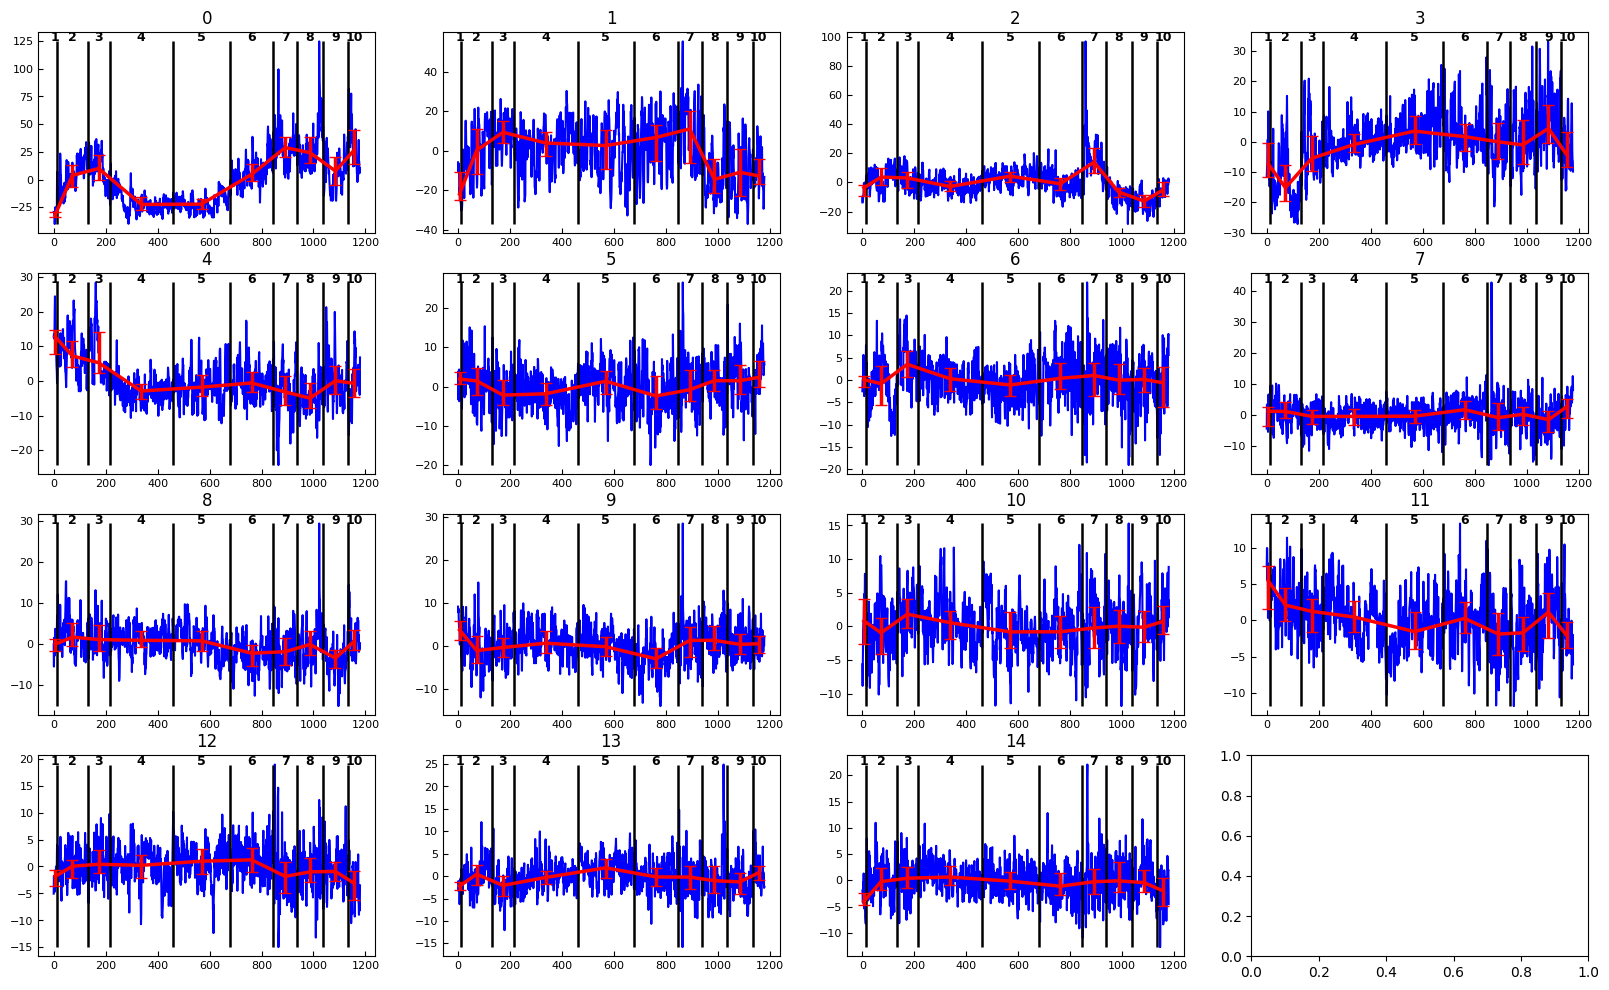

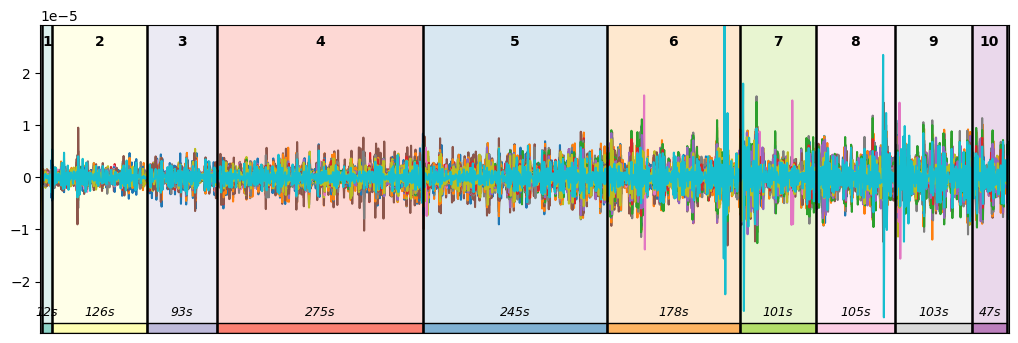

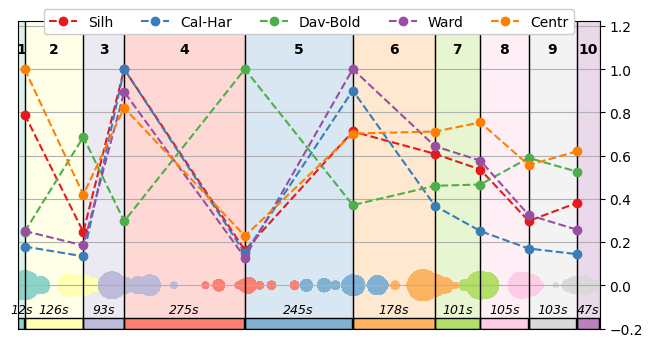

In [59]:
internal_edges = analyze(result, df_st_edges, 'Avg-Silh', "internal")

#### External

,St_len_min,K_nb_max,N_cl_max,N_stages,Cl_cen,St_edges,Ward_dist,Cen_dist,Silh,Cal-Har,Dav-Bold,Avg-Silh,Avg-Cal-Har,Avg-Dav-Bold,AMI,ARI,FMI
0,60,35,10,3,Mode,"[0, 243, 822, 1180]",218956.28,31.36,1.31e-01,233.06,2.26,0.24,277.27,1.78,0.57,0.34,0.53
1,60,35,10,4,Median,"[0, 221, 683, 938, 1180]",139664.05,29.83,1.58e-01,214.73,2.50,0.24,215.32,1.82,0.72,0.51,0.65
2,60,35,10,5,Mode,"[0, 243, 679, 822, 949, 1180]",83332.61,28.51,1.18e-01,191.26,2.44,0.23,135.03,1.76,0.72,0.53,0.64
3,40,35,20,6,Median,"[0, 190, 458, 679, 906, 1040, 1180]",62207.44,23.22,1.68e-02,137.20,3.38,0.15,88.30,2.50,0.82,0.72,0.77
4,40,35,15,7,Median,"[0, 190, 462, 679, 822, 939, 1040, 1180]",46448.16,23.20,1.80e-02,135.29,3.25,0.16,72.46,2.42,0.85,0.76,0.80
5,20,40,10,8,Median,"[0, 156, 215, 467, 683, 822, 939, 1040, 1180]",35692.78,22.94,8.35e-03,121.77,3.32,0.16,59.78,2.47,0.86,0.79,0.82
6,40,40,20,9,Median,"[0, 103, 190, 267, 460, 679, 822, 939, 1040, 1...",33442.55,22.82,8.91e-03,118.27,3.17,0.16,55.33,2.25,0.88,0.83,0.86
7,40,35,20,10,Median,"[0, 103, 190, 264, 458, 679, 822, 938, 1040, 1...",34303.78,24.48,1.21e-02,113.31,4.01,0.17,54.88,2.05,0.90,0.87,0.89
8,0,45,15,11,Median,"[0, 13, 132, 190, 264, 467, 683, 829, 938, 103...",30959.60,25.70,9.87e-03,103.33,3.61,0.18,49.40,2.01,0.91,0.87,0.89
9,0,40,15,12,Median,"[0, 13, 133, 190, 264, 467, 679, 729, 829, 938...",22996.33,23.85,8.03e-03,95.44,3.68,0.16,35.66,2.18,0.90,0.86,0.88


,St_len_min,K_nb_max,N_cl_max,N_stages,Cl_cen,St_edges,Ward_dist,Cen_dist,Silh,Cal-Har,Dav-Bold,Avg-Silh,Avg-Cal-Har,Avg-Dav-Bold,AMI,ARI,FMI
0,40,35,20,10,Median,"[0, 103, 190, 264, 458, 679, 822, 938, 1040, 1...",34303.78,24.48,0.01,113.31,4.01,0.17,54.88,2.05,0.9,0.87,0.89


array([   0,  103,  190,  264,  458,  679,  822,  938, 1040, 1129, 1180])

,Silh,Cal-Har,Dav-Bold,Ward,Centr
0,0.16,48.14,1.89,32821.71,26.38
1,0.23,55.20,1.61,28134.76,26.53
2,0.22,57.82,1.89,18863.52,18.77
3,0.06,28.44,3.59,10698.88,10.18
4,0.24,127.19,1.60,62176.31,26.76
5,0.20,66.28,1.84,54178.64,29.08
6,0.16,41.63,2.06,44083.66,28.50
7,0.13,37.01,2.09,32216.30,26.04
8,0.17,32.18,1.92,25560.21,28.08


,0,1,2,3,4,5,6,7,8,9
"Start-end time, sec","(8.5, 116.5)","(117.5, 214.5)","(215.5, 298.5)","(299.5, 516.5)","(517.5, 765.5)","(766.5, 919.5)","(920.5, 1046.5)","(1047.5, 1156.5)","(1161.5, 1250.5)","(1251.5, 1304.5)"
"Time length, sec",108.0,97.0,83.0,217.0,248.0,153.0,126.0,109.0,89.0,53.0
Number of epochs,103,87,74,194,221,143,116,102,89,51


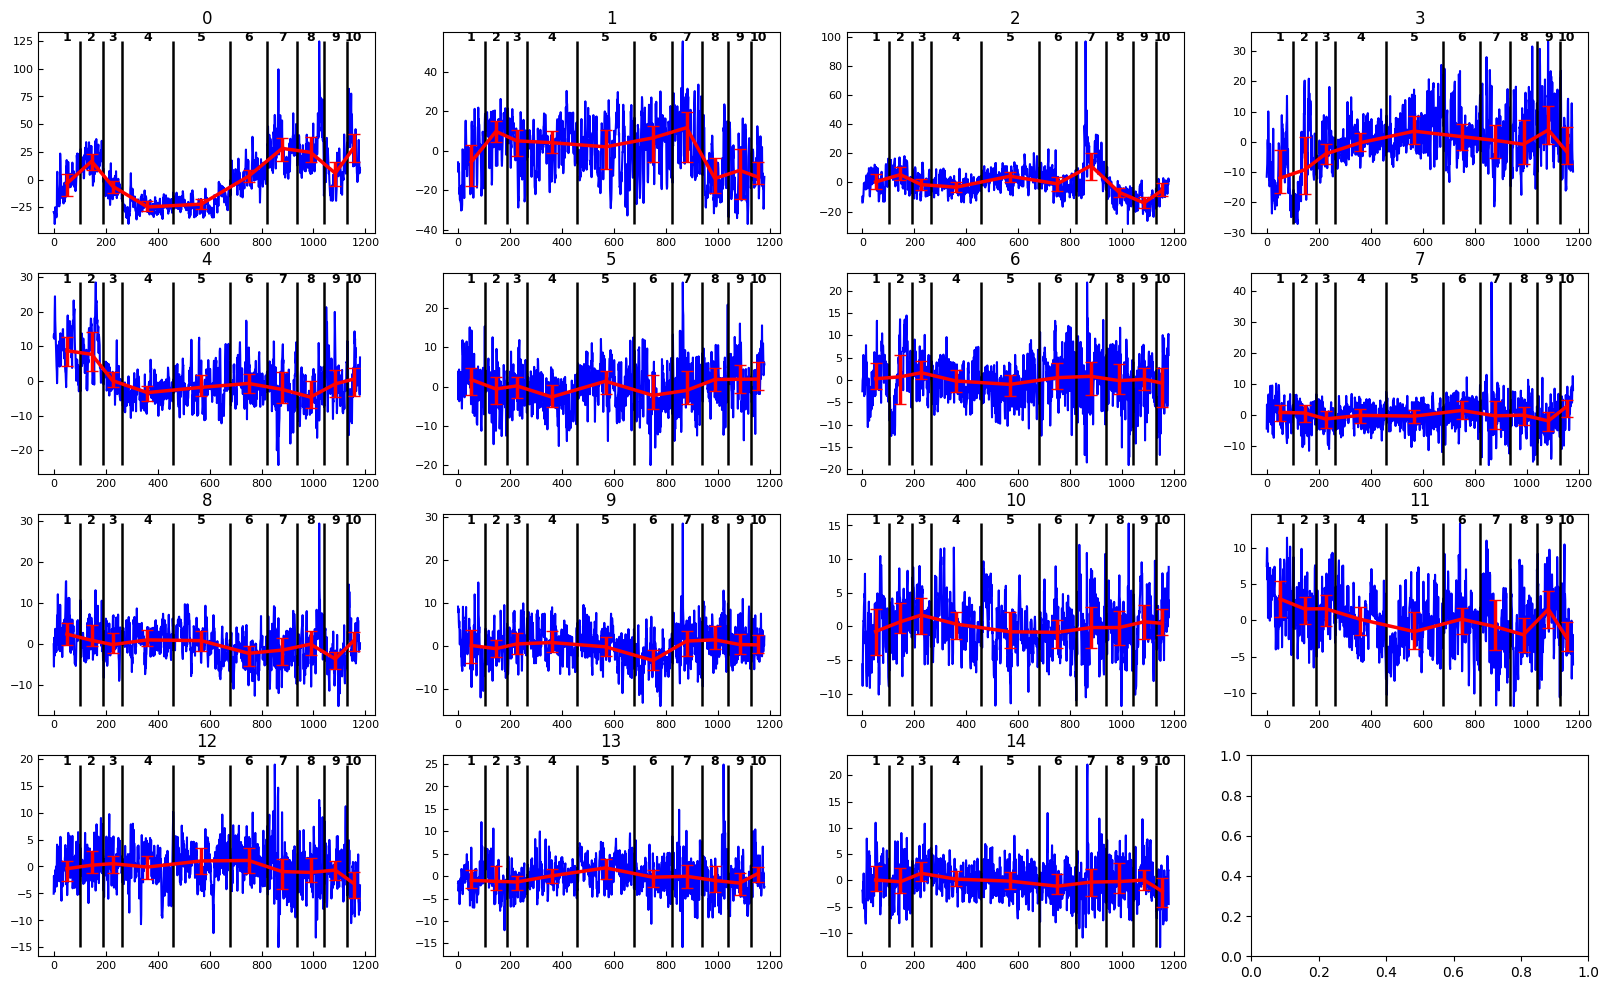

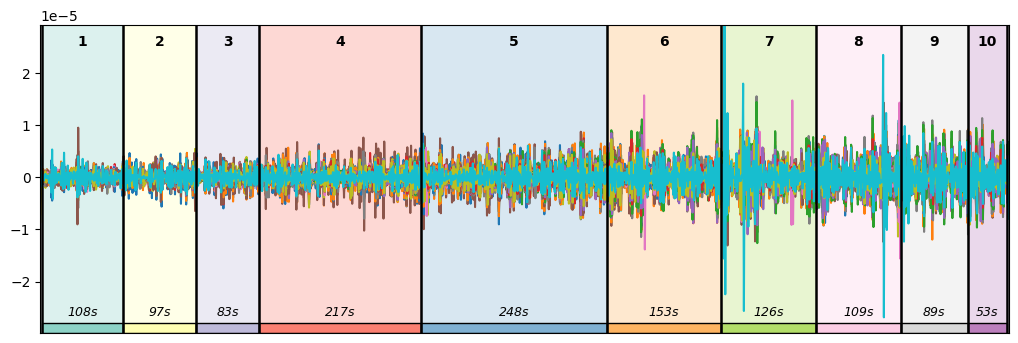

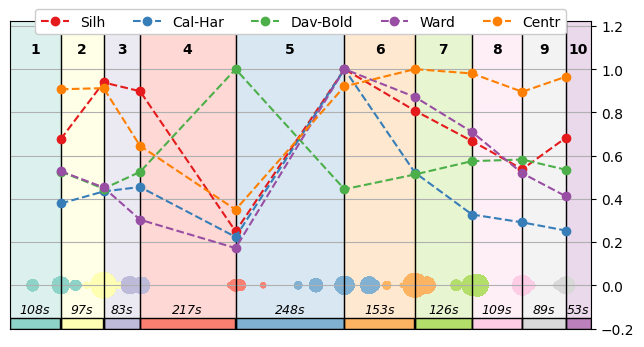

In [60]:
external_edges = analyze(result, df_st_edges, 'FMI', "external")

### IV

In [11]:
IV = pandas.DataFrame(df_all_features.columns, columns = [ "Feature" ])
for edges, name, path in zip(
    [ edges_true, internal_edges, external_edges ],
    [ "true", "internal", "external" ],
    [ "true_iv", "internal/iv", "external/iv" ]
):
    _, labels = SDA.stageprocess.form_stage_bands(edges)
    edges_iv = SDA.analytics.IV.calc_IV_clust(df_all_features, labels)
    edges_iv.to_csv(f"{subj}/{exp}/{path}.csv")
    IV[name] = edges_iv["IV"]
IV

  0%|          | 0/1530 [00:00<?, ?it/s]

 29%|██▉       | 443/1530 [00:13<00:33, 32.04it/s]


KeyboardInterrupt: 

In [ ]:
IV["internal-diff"] = IV["true"] - IV["internal"]
IV["external-diff"] = IV["true"] - IV["external"]
IV.to_csv(f"{subj}/{exp}/IV.csv")
IV

,Feature,true,internal,external,internal-diff,external-diff
0,channel-0 betti dim-1 max,0.34,0.34,0.33,1.92e-03,0.01
1,channel-0 betti dim-1 mean,0.00,0.00,0.00,0.00e+00,0.00
2,channel-0 betti dim-1 std,0.44,0.45,0.40,-3.51e-03,0.05
3,channel-0 betti dim-1 sum,0.00,0.00,0.00,0.00e+00,0.00
4,channel-0 betti dim-1 percentile-25,0.00,0.00,0.00,0.00e+00,0.00
...,...,...,...,...,...,...
19558,overall bd2 dim-3 percentile-75,0.70,0.68,0.62,2.77e-02,0.08
19559,overall bd2 dim-3 kurtosis,0.15,0.15,0.13,2.26e-03,0.02
19560,overall bd2 dim-3 skew,0.19,0.19,0.18,-3.82e-04,0.01
19561,overall bd2 dim-3 norm-1,0.44,0.44,0.40,-3.16e-03,0.04


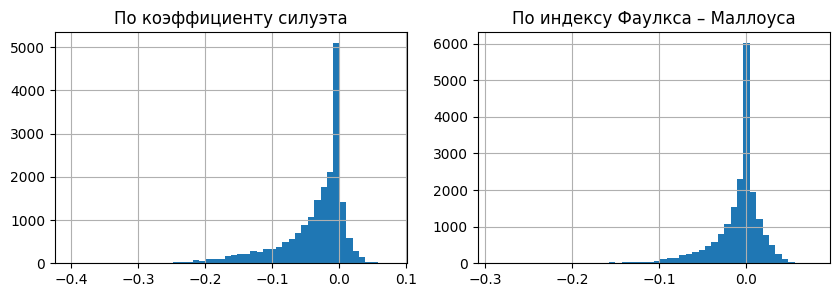

In [ ]:
fig, axes = plt.subplots(1, 2, figsize = (10, 3))

axes[0].set_title('По коэффициенту силуэта')
IV["internal-diff"].hist(ax = axes[0], bins = 50)

axes[1].set_title('По индексу Фаулкса – Маллоуса')
IV["external-diff"].hist(ax = axes[1], bins = 50)

plt.savefig(f"{subj}/{exp}/IV-diffs.svg")
plt.savefig(f"{subj}/{exp}/IV-diffs.png")